In [1]:
from transformers import ViTForImageClassification, ViTImageProcessor
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm.auto import tqdm

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# print cuda device information
print(torch.cuda.get_device_name(0))

NVIDIA GeForce RTX 4090


In [2]:

# Load Pre-Trained ViT Model
vit_model = ViTForImageClassification.from_pretrained(
    "google/vit-base-patch16-224",
    num_labels=100,  # Adjust for CIFAR-100
    id2label={i: str(i) for i in range(100)},
    label2id={str(i): i for i in range(100)},
    ignore_mismatched_sizes=True  # Ignore size mismatch for the classification head
)
vit_model.to(device)


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([100]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([100, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fe

In [3]:
processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224')

In [4]:
# Data Preprocessing
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=processor.image_mean, std=processor.image_std),
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=processor.image_mean, std=processor.image_std),
])

# Load CIFAR-100 Dataset
train_dataset = datasets.CIFAR100(root="./data", train=True, download=True, transform=train_transform)
test_dataset = datasets.CIFAR100(root="./data", train=False, download=True, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


Files already downloaded and verified
Files already downloaded and verified


In [5]:
def train_and_evaluate_model(model, train_loader, test_loader, optimizer, criterion, device, num_epochs):
    train_acc = []
    test_acc = []
    for epoch in range(num_epochs):
        # Initialize a new progress bar for each epoch
        progress_bar = tqdm(total=len(train_loader) + len(test_loader), desc=f"Epoch {epoch + 1}/{num_epochs} - Train Acc: 0.000 - Val Acc: 0.000", unit="batch")
        
        # Initialize variables for training phase
        train_correct = 0
        train_total = 0
        
        # Training Phase
        model.train()
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(pixel_values=images)
            loss = criterion(outputs.logits, labels)
            loss.backward()
            optimizer.step()
            
            _, predicted = outputs.logits.max(1)
            train_correct += predicted.eq(labels).sum().item()
            train_total += labels.size(0)
            
            # Update training accuracy
            train_accuracy = train_correct / train_total
            progress_bar.set_description(f"Epoch {epoch + 1}/{num_epochs} - Train Acc: {train_accuracy:.4f}")
            progress_bar.update(1)  # Update progress bar for each training batch
        
        train_acc.append(train_accuracy)
        
        # Initialize variables for validation phase
        val_correct = 0
        val_total = 0
        
        # Validation Phase
        model.eval()
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(pixel_values=images)
                loss = criterion(outputs.logits, labels)
                
                _, predicted = outputs.logits.max(1)
                val_correct += predicted.eq(labels).sum().item()
                val_total += labels.size(0)
                
                # Update validation accuracy
                val_accuracy = val_correct / val_total
                progress_bar.set_description(f"Epoch {epoch + 1}/{num_epochs} - Train Acc: {train_accuracy:.4f} - Val Acc: {val_accuracy:.4f}")
                progress_bar.update(1)  # Update progress bar for each validation batch
                
        test_acc.append(val_accuracy)

        # Reset the progress bar description for the next epoch
        progress_bar.set_description(f"Epoch {epoch + 1}/{num_epochs} - Train Acc: {train_accuracy:.4f} - Val Acc: {val_accuracy:.4f}")
        progress_bar.close()
        
    return train_acc, test_acc

# Call the function
num_epochs = 5
# Loss Function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(vit_model.parameters(), lr=0.0001, weight_decay=0.01)
train_acc, test_acc = train_and_evaluate_model(vit_model, train_loader, test_loader, optimizer, criterion, device, num_epochs)

# Save the Fine-Tuned Model
vit_model.save_pretrained("./vit-finetuned-cifar100")

Epoch 1/5 - Train Acc: 0.000 - Val Acc: 0.000:   0%|          | 0/1876 [00:00<?, ?batch/s]

Epoch 2/5 - Train Acc: 0.000 - Val Acc: 0.000:   0%|          | 0/1876 [00:00<?, ?batch/s]

Epoch 3/5 - Train Acc: 0.000 - Val Acc: 0.000:   0%|          | 0/1876 [00:00<?, ?batch/s]

Epoch 4/5 - Train Acc: 0.000 - Val Acc: 0.000:   0%|          | 0/1876 [00:00<?, ?batch/s]

Epoch 5/5 - Train Acc: 0.000 - Val Acc: 0.000:   0%|          | 0/1876 [00:00<?, ?batch/s]

In [6]:
# print table of train and test accuracy
print("Epoch\tTrain Acc\tTest Acc")
for i in range(num_epochs):
    print(f"{i + 1}\t{train_acc[i]:.4f}\t{test_acc[i]:.4f}")


Epoch	Train Acc	Test Acc
1	0.8334	0.8824
2	0.9297	0.8864
3	0.9533	0.8706
4	0.9626	0.8831
5	0.9723	0.8769


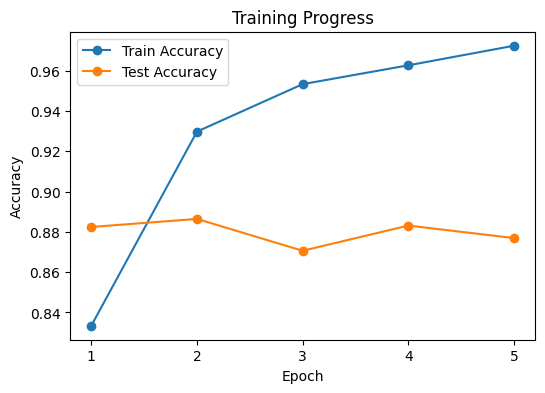

In [12]:
# Plot train and test accuracy
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
plt.plot(range(1, num_epochs + 1), train_acc, label="Train Accuracy", marker="o")
plt.plot(range(1, num_epochs + 1), test_acc, label="Test Accuracy", marker="o")
plt.title("Training Progress")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend()
plt.xticks(range(1, num_epochs + 1))
plt.show()

In [ ]:
from huggingface_hub import PyTorchModelHubMixin
vit_model.push_to_hub("Swapnil949/vit-finetuned-cifar100", use_temp_dir=True)

NameError: name 'model' is not defined